In [23]:
from scipy.stats import kde
import h5py
import astropy.io.fits as fits
import csv
import pandas as pd
import numpy as np
import tables
import pickle
import os
from astropy.table import Table
from astropy.coordinates import SkyCoord
from tqdm import tqdm
from astropy.io import ascii
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import incredible as cr
from scipy.special import erf
from scipy import stats
import scipy.optimize as opt
from scipy import stats
import scipy.optimize as opt
import emcee
import tqdm

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [6]:
import sys
sys.path.append('/global/u1/z/zzhang13')
from kllr.kllr.regression_model import *
from kllr.kllr.regression_plotting import *
from kllr.kllr.calc_cov_KLLR import *

In [4]:
chains_dir = '/global/homes/z/zzhang13/BaryonPasting/CorrelatedStructures/multiDark/data/chains/'
datadir = '/global/homes/z/zzhang13/BaryonPasting/CorrelatedStructures/multiDark/data/'
plot_dir = '/global/homes/z/zzhang13/BaryonPasting/CorrelatedStructures/multiDark/plots/'

In [5]:
with open(datadir + 'MDPL2_DS_Rvir_SAGE_Ngal_allM_allz.p', 'rb') as handle:
    matched_halo_df = pickle.load(handle)
matched_halo_df.columns

Index(['scale', 'CtreesHaloID', 'pid', 'mvir', 'rvir', 'rs', 'x', 'y', 'z',
       'Mmvir_all', 'M200b', 'M200c', 'M500c', 'T/|U|', 'Halfmass_Scale',
       'Acc_Rate_Inst', 'Acc_Rate_100Myr', 'Acc_Rate_1*Tdyn',
       'Acc_Rate_2*Tdyn', 'Acc_Rate_Mpeak', 'c_vir', 'R200c', 'R500c',
       'redshift', 'Ngal_Dsep_1', 'Ngal_Rvir', 'Ngal_R200c', 'Ngal_R500c',
       'sigma', 'r_range', 'delta_sigma'],
      dtype='object')

In [32]:
'''
Uniform priors on tau, gamma and height. Log uniform (1/s) prior on s. 
Input: p as len(4) or (4,N) array with N being the posterior sample.
Output: Log prior proabability in same dimensions as p
'''
def lnprior(p):
    tau = p[0]; gamma = p[1]; height = p[2]; scale = p[3]
    
    #Uniform prior ranges
    tau_uniform = (tau > 0) & (tau < 10)
    gamma_uniform = (gamma > -5) & (gamma < 5)
    h_uniform = (height > -2) & (height < 1)
    s_uniform = (scale/1e12 > 1e-2) & (scale/1e12 < 10)
    
    filt = tau_uniform & gamma_uniform & h_uniform & s_uniform
    lnp = np.zeros_like(tau, dtype=float)
    lnp[~filt] = -np.inf
    lnp[filt] = -np.log(scale) ##Uniform log prior
    
    return lnp

'''
Gaussian likelihood with heterodescitic errors

Input:
p: 4-parameters of dimensions (4) or (4,N) with N the array of posterior samples
model: functional model for the fit (see functions below)
x: x data vector
y: y data vector
err: error on the y data vector

Returns:
lp: log probability of dimensions (N)
'''
def lnlike(p, model, x, y, err):
    # the likelihood is sum of the lot of normal distributions
    x = x[:,np.newaxis]
    y = y[:,np.newaxis]
    err = err[:,np.newaxis]
    
    fit = model(p,x)
    if np.any(np.isnan(fit)):
        return -np.inf

    denom = np.power(err,2)
    lp = -0.5*np.sum(np.power((y - fit),2)/denom + np.log(denom) + np.log(2*np.pi), axis=0)
    lp = np.nan_to_num(lp, nan=-np.inf)
    return lp


'''
Posterior likelihood. Calls lnlike() and lnprior().

Input:
p: 4-parameters of dimensions (4) or (4,N) with N the array of posterior samples
model: functional model for the fit (see functions below)
x: x data vector
y: y data vector
err: error on the y data vector

Returns:
lp: log probability of dimensions (N)
'''
def lnprob(p, model, x, y, err):
    lp = lnprior(p)

    return lp + lnlike(p, model, x, y, err)
    
    
    
    
def model_logistics(p, x):
    tau = p[0]; gamma = p[1]; height = p[2]; scale = p[3]
    x_tilde = (x-gamma)/tau
    model = scale * (2./(1 + np.exp(-2*x_tilde)) -1 + height)
    return model

def model_logistics_gen(p, x):
    tau = p[0]; gamma = p[1]; height = p[2]; scale = p[3]; k=p[4]
    alpha = -np.log(2**(1./k)-1)
    x_tilde = (x-gamma)/tau
    
    model = scale* (2*(1/(1+np.exp(-(2*x_tilde+alpha)))**k)-1 + height)
    return model

def model_algebraic_gen(p,x):
    tau = p[0]; gamma = p[1]; height = p[2]; scale = p[3]; k = p[4]
    x_tilde = (x-gamma)/tau

    model = scale* (x_tilde/(1 + np.abs(x_tilde)**k)**(1./k) + height)
    return model

def model_algebraic_2nd(p,x):
    tau = p[0]; gamma = p[1]; height = p[2]; scale = p[3]
    x_tilde = (x-gamma)/tau
    model = scale* (x_tilde/(1 + np.abs(x_tilde)**2)**(1./2) + height)
    return model

def model_erf(p,x):
    tau = p[0]; gamma = p[1]; height = p[2]; scale = p[3]
    x_tilde = (x-gamma)/tau
    model = scale* (erf(np.sqrt(np.pi)/2*x_tilde) + height)
    return model

def model_arctan(p,x):
    tau = p[0]; gamma = p[1]; height = p[2]; scale = p[3]
    x_tilde = (x-gamma)/tau
    model = scale* (2/np.pi*np.arctan(np.pi/2*x_tilde) + height)
    return model


In [10]:
model_dict ={'logistics':{'Ndim':4, 'model_func':model_logistics, 'x0':[0.5, -0.5, -1, 1e12], 'x_final:':[],
                         },
             
             #'logistics_gen':{'Ndim':5, 'model_func': model_logistics_gen, 'x0':[0.5, -0.5, -1, 1.5e12, 1], 'x_final:':[],
             #            },
             
             'algebraic_2nd':{'Ndim':4, 'model_func':model_algebraic_2nd, 'x0':[0.5, -0.5, -1, 1e12], 'x_final:':[],
                         },
             
             #'algebraic_gen':{'Ndim':5, 'model_func':model_algebraic_gen, 'x0':[0.5, -0.5, -1, 1.5e12, 1], 'x_final:':[],
             #           },
             
             'arctan':{'Ndim':4, 'model_func':model_arctan, 'x0':[0.5, -0.5, -1, 1e12], 'x_final:':[],
                         },
             
             'erf':{'Ndim':4, 'model_func':model_erf, 'x0':[0.5, -0.5, -1, 1e12], 'x_final:':[],
                         }
            }

In [11]:
## Testing the file properties. 
r_bins_log_norm = np.linspace(-1,1,21)
r_bins_lin_norm = 10**r_bins_log_norm
r_cent_log_norm= (r_bins_log_norm[1:] + r_bins_log_norm[:-1])/2
r_cent_lin_norm = 10**r_cent_log_norm

In [15]:
nBootstrap = 10
mass_min = 1e14; mass_max =2e14
cur_a_bin = 0.6712

mask = (matched_halo_df.mvir >= mass_min) & (matched_halo_df.mvir < mass_max) & (matched_halo_df.scale == cur_a_bin) 
cur_df = matched_halo_df[mask]
print('M{:.2g}-{:.2g}, z={:.2f}, {}'.format(mass_min, mass_max, 1/cur_a_bin-1, len(cur_df)))
            
##Computing the Covariance##
##Compute Cov. and error total
xline, output = calc_cov_KLLR(np.log10(np.array(cur_df['M200c'],dtype=float)) , np.array(np.vstack(cur_df['delta_sigma']), dtype=float), \
                                np.log10(np.array(cur_df['Ngal_Dsep_1'],dtype=float)), nBootstrap=nBootstrap)
cov_ds_ngal_kllr = output['covariance']
cov_mean_kllr = np.mean(cov_ds_ngal_kllr, axis=0)
cov_err_kllr = np.std(cov_ds_ngal_kllr, axis=0)
        
##Data vector for chains
x_data = r_cent_log_norm; y_data = cov_mean_kllr; y_err = cov_err_kllr

M1e+14-2e+14, z=0.49, 500


In [16]:
for k,v in model_dict.items():
    if k != 'erf': continue
    print(k)
    Ndim = v['Ndim']
    model = v['model_func']
    x0 = v['x0']

erf


In [20]:
Nwalkers = 50
Nsample = int(1e4)

mass_min = 5e14; mass_max = 1e15
cur_a_bin = 0.6712

redshift = 1/cur_a_bin - 1
redshift_str = '{:.2f}'.format(redshift)
redshift_str = redshift_str.replace('.','p')

In [34]:
p0 = np.array([x0*(1.0 + 0.01*np.random.randn(Ndim)) for j in range(Nwalkers)])

In [35]:
# Initialize the sampler        
sampler = emcee.EnsembleSampler(Nwalkers, Ndim, lnprob,
                    args=(model, x_data, y_data, y_err)) ##No backend
        
sampler.run_mcmc(p0, Nsample, progress=True) 

100%|██████████| 10000/10000 [01:01<00:00, 163.06it/s]


State([[ 3.80495989e-01 -5.89267743e-01 -1.00251829e+00  5.50384349e+11]
 [ 8.78786208e-01 -1.62464967e+00 -9.96638848e-01  3.08741076e+12]
 [ 8.38412884e-01 -1.30776079e+00 -9.87827941e-01  1.62935947e+12]
 [ 7.37471140e-01 -1.14980247e+00 -9.89956344e-01  1.34160788e+12]
 [ 1.06838613e+00 -1.72411129e+00 -9.93979343e-01  2.25792739e+12]
 [ 3.89059305e-01 -6.47115276e-01 -9.90866396e-01  5.48586137e+11]
 [ 7.80434236e-01 -1.34854081e+00 -9.97018108e-01  2.11867514e+12]
 [ 9.26269160e-01 -1.50505448e+00 -9.94527502e-01  1.99486708e+12]
 [ 9.46520383e-01 -1.71583335e+00 -1.00079298e+00  2.93328408e+12]
 [ 8.74642922e-01 -1.60271886e+00 -9.95080778e-01  3.33601795e+12]
 [ 6.81724530e-01 -1.01988884e+00 -9.97594372e-01  1.27103414e+12]
 [ 9.12201211e-01 -1.76924218e+00 -9.99262280e-01  4.50524239e+12]
 [ 8.60197291e-01 -1.35064799e+00 -9.91354167e-01  1.61432944e+12]
 [ 5.93929382e-01 -8.23834775e-01 -9.93995184e-01  8.70683449e+11]
 [ 8.45083746e-01 -1.39251926e+00 -9.92830579e-01  1.885

In [38]:
chain = sampler.get_chain(flat=False, thin=1000, discard=500)

In [39]:
def check_chains(chain, burn=0, maxlag=1000):
    '''
    Ignoring `burn` samples from the front of each chain, compute convergence criteria and
    effective number of samples.
    '''
    nsteps, nwalk, npars = chain.shape
    if burn >= nsteps: return
    tmp_samples = [chain[burn:,i,:] for i in range(nwalk)]
    print('R =', cr.GelmanRubinR(tmp_samples))
    #print('neff =', cr.effective_samples(tmp_samples, maxlag=maxlag))
    #print('NB: Since walkers are not independent, these will be optimistic!')
    return

In [40]:
check_chains(chain)

R = [1.0120617  1.00420617 0.98407244 0.99751427]


In [45]:
flatchain = chain.reshape((-1,4)).T

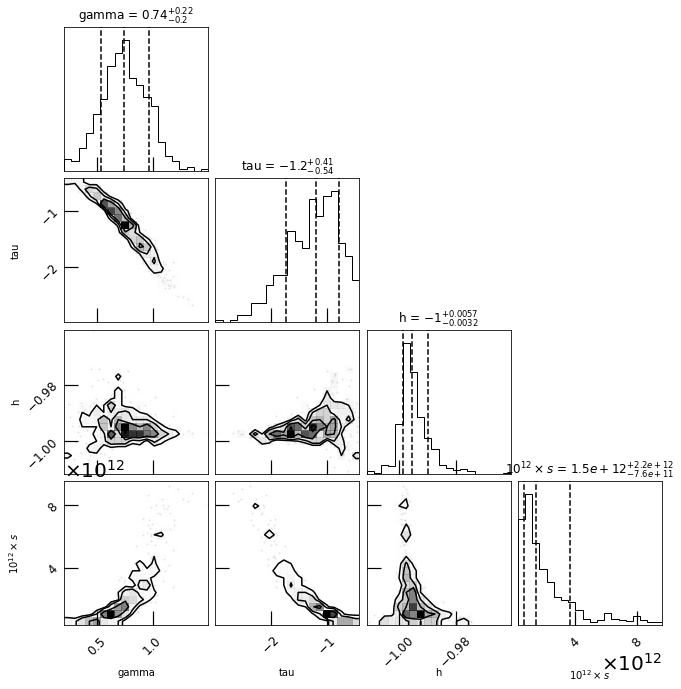

In [46]:
import corner
tmp = corner.corner(flatchain.T, labels=['gamma', 'tau', 'h', r'$10^{12}\times s$'],
                    quantiles=[0.16, 0.5, 0.84],
                    show_titles=True,
                    title_kwargs={"fontsize": 12},
                    title_fmt='.2g',
                    #axes_scale=['linear','linear','linear','log'],
                    max_n_ticks=3,
                    use_math_text=True,
                    #range=[(0,0.4),(-2,0),(0.9,1),(1e12,1e13)]
                   )
for i, ax in enumerate(tmp.get_axes()):
    #if i==12: ax.set_xscale('log')
    #if i>=13: ax.set_yscale('log')
    ax.tick_params(axis='both', labelsize=12)
#tmp.savefig(plot_dir + 'mcmc_logistic_cornerplot.pdf')

In [31]:
print(p0[0])

[ 5.03520607e-01 -5.02359014e-01 -1.00791679e+00  1.00655344e+12]
